In [1]:
import numpy as np
import pandas as pd
from keras import optimizers, losses, activations, models
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from keras.layers import Dense, Input, Dropout, Convolution1D, MaxPool1D, GlobalMaxPool1D, GlobalAveragePooling1D,concatenate,BatchNormalization
from keras import regularizers
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
import librosa
from playsound import playsound
from tensorflow import keras
import tensorflow as tf
import glob
import os
import noisereduce as nr
from keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score,recall_score,accuracy_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
df=pd.read_csv("recordings-diagnosis.csv")

In [3]:
df.head(5)

,professional-diagnosis,file_name
0,False,audio_audio.m4a-b68fe4c0-db31-4b39-8f8f-7fb874...
1,False,audio_audio.m4a-3e719e45-187b-4cbb-8ce1-8ccf37...
2,False,audio_audio.m4a-579f1a37-3edd-4df7-b80b-bffc14...
3,False,audio_audio.m4a-eeee8102-596c-4030-8f77-b40460...
4,False,audio_audio.m4a-4374d36b-4020-4e7a-860b-44aadf...


In [4]:
df['professional-diagnosis'].value_counts()

True     39257
False    22780
Name: professional-diagnosis, dtype: int64

In [5]:
files_dir= "wav_files"

In [6]:
class CFG:
    # batch_size and epochs
    batch_size = 64
    epochs = 100
    patience = 35 
    patience_for_plato = 10
    model = 1 # 1 for Regular model. 2 for Resnet model. 3 for Attention model
    feature_extract_train = False # To create new data
    feature_extract_test = False
    load_weights = True
    save_weights = False

In [7]:
# data =[]
# for path in os.listdir(files_dir):
#     isPD = df["professional-diagnosis"].loc[df["file_name"]==path].values[0]
#     data.append(Audio_File(os.path.join(files_dir,path),isPD))

# Data Augmentation

* Data augmentation is the process by which we create new synthetic data samples by adding small perturbations on our initial training set.

* To generate syntactic data for audio, we can apply noise injection, shifting time, changing pitch and speed.

* The objective is to make our model invariant to those perturbations and enhace its ability to generalize.

* In order to this to work adding the perturbations must conserve the same label as the original training sample.
* In images data augmention can be performed by shifting the image, zooming, rotating ...

First, let's check which augmentation techniques works better for our dataset.

In [8]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
path = r'wav_files\audio_audio.m4a-0a0a533c-bca3-4341-8c28-8f68bfc4815c868532989709666129.wav'
data, sample_rate = librosa.load(path)

## Feature Extraction
- Extraction of features is a very important part in analyzing and finding relations between different things. As we already know that the data provided of audio cannot be understood by the models directly so we need to convert them into an understandable format for which feature extraction is used.


The audio signal is a three-dimensional signal in which three axes represent time, amplitude and frequency.

![image.png](https://miro.medium.com/max/633/1*7sKM9aECRmuoqTadCYVw9A.jpeg)

I am no expert on audio signals and feature extraction on audio files so i need to search and found a very good blog written by [Askash Mallik](https://medium.com/heuristics/audio-signal-feature-extraction-and-clustering-935319d2225) on feature extraction.

As stated there with the help of the sample rate and the sample data, one can perform several transformations on it to extract valuable features out of it.
1. Zero Crossing Rate : The rate of sign-changes of the signal during the duration of a particular frame.
2. Energy : The sum of squares of the signal values, normalized by the respective frame length.
3. Entropy of Energy : The entropy of sub-frames’ normalized energies. It can be interpreted as a measure of abrupt changes.
4. Spectral Centroid : The center of gravity of the spectrum.
5. Spectral Spread : The second central moment of the spectrum.
6. Spectral Entropy :  Entropy of the normalized spectral energies for a set of sub-frames.
7. Spectral Flux : The squared difference between the normalized magnitudes of the spectra of the two successive frames.
8. Spectral Rolloff : The frequency below which 90% of the magnitude distribution of the spectrum is concentrated.
9.  MFCCs Mel Frequency Cepstral Coefficients form a cepstral representation where the frequency bands are not linear but distributed according to the mel-scale.
10. Chroma Vector : A 12-element representation of the spectral energy where the bins represent the 12 equal-tempered pitch classes of western-type music (semitone spacing).
11. Chroma Deviation : The standard deviation of the 12 chroma coefficients.


In this project i am not going deep in feature selection process to check which features are good for our dataset rather i am only extracting 5 features:
- Zero Crossing Rate
- Chroma_stft
- MFCC
- RMS(root mean square) value
- MelSpectogram to train our model.

In [9]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally
   
    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=16000).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=16000).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=16000).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    

    # Spectral Bandwidth
    sb = np.mean(librosa.feature.spectral_bandwidth(y=data,sr=16000), axis=0)[:356]
    result = np.hstack((result, sb)) # stacking horizontally

    # Spectral Centroid
    sc = np.mean(librosa.feature.spectral_centroid(y=data,sr=16000), axis=0)[:356]
    result = np.hstack((result, sc)) # stacking horizontally
   
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=10, offset=0.6)
    try:
        # without augmentation
        res1 = extract_features(data)
        result = np.array(res1)
        
        # data with noise
        noise_data = noise(data)
        res2 = extract_features(noise_data)
        result = np.vstack((result, res2)) # stacking vertically
        
        # data with stretching and pitching
        new_data = stretch(data)
        data_stretch_pitch = pitch(new_data, sample_rate)
        res3 = extract_features(data_stretch_pitch)
        result = np.vstack((result, res3)) # stacking vertically
    except Exception as e:
        print(e)
    return result

In [10]:
if CFG.feature_extract_train:
    X, Y = [], []
    for i,file in enumerate(os.listdir(files_dir)[:5000]):
        feature = get_features(os.path.join(files_dir,file))
        for ele in feature:
            X.append(ele)
            # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
            Y.append(df["professional-diagnosis"].loc[df["file_name"]==file].values[0])
        if(i%100==0):
            print(i)
    len(X), len(Y)
    Features = pd.DataFrame(X)
    Features['labels'] = Y
    Features.to_csv('features.csv', index=False)
    Features.head()

In [13]:
Features = pd.read_csv("features.csv")

## Data Preparation

- As of now we have extracted the data, now we need to normalize and split our data for training and testing.

In [14]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [15]:
# splitting data
x_train, x_val, y_train, y_val = train_test_split(X, Y, random_state=42,test_size=0.1)
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((13500, 874), (13500,), (1500, 874), (1500,))

In [16]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((13500, 874), (13500,), (1500, 874), (1500,))

In [17]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_val = np.expand_dims(x_val, axis=2)
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((13500, 874, 1), (13500,), (1500, 874, 1), (1500,))

## Modelling


In [18]:


def conv1d(x, filters, kernel_size, name, stride=1, activation=tf.nn.elu, padding='SAME'):
    return tf.keras.layers.Convolution1D( filters, kernel_size, strides=stride, padding='SAME',name=name,kernel_regularizer=regularizers.L2(0.001))(x)

def maxpool1d(x, pool_size, strides, name, padding='SAME'):
    return tf.keras.layers.MaxPool1D( pool_size, strides, padding='SAME', name=name)(x)

def resblock(x, filters, kernel_size, name):
    resblock=conv1d(x, filters, kernel_size, stride=1, name=name+'_conv1')
    resblock=tf.keras.layers.BatchNormalization( name=name+'_batch1')(resblock)
    resblock=tf.nn.relu(resblock, name=name+'_relu')
    resblock=conv1d(resblock, filters, kernel_size, stride=1, name=name+'_conv2')
    resblock=tf.keras.layers.BatchNormalization( name=name+'_batch2')(resblock)
    return tf.nn.relu(resblock+x)

def fullylayer(x, units, name):
    return tf.keras.layers.dense(x, units, activation=tf.nn.elu, name=name)

def conv2ser(x):
    return tf.keras.layers.GlobalAveragePooling1D()(x)

def resblock_s(x, filters, kernel_size, name):
    resblock=conv1d(x, filters, kernel_size, stride=2, name=name+'_conv1')
    shorcut=tf.keras.layers.BatchNormalization( name=name+'_batch1')(resblock)
    resblock=tf.nn.relu(shorcut, name=name+'_relu')
    resblock=conv1d(resblock, filters, kernel_size, stride=1, name=name+'_conv2')
    resblock=tf.keras.layers.BatchNormalization( name=name+'_batch2')(resblock)
    return tf.nn.relu(resblock+shorcut)  

In [19]:
class BaseModel:
    def __init__(self, num_class):
        raise NotImplementedError
        
    def run(self, X, is_training):
        raise NotImplementedError

class Resnet1D(BaseModel):
    params={}
    def __init__(self, num_class, keep_prob):
        self.shape=[-1, 74484, 1]
        self.keep_prob=keep_prob
        
    
        

In [20]:
def get_model():
    if CFG.model==1:
        inp = Input(shape=(874, 1))
        img_1 = Convolution1D(256, kernel_size=5,strides  =1, activation=activations.relu, padding="same",kernel_initializer="he_normal")(inp)
        img_1 = MaxPool1D(pool_size=5,strides = 2,padding="same")(img_1)
        img_1 = BatchNormalization()(img_1)
        img_1 = Convolution1D(128, kernel_size=5,strides  =1 ,activation=activations.relu, padding="same",kernel_initializer="he_normal")(img_1)
        img_1 = MaxPool1D(pool_size=5,strides = 2)(img_1)
        img_1 = BatchNormalization()(img_1)
        img_1 = Convolution1D(128, kernel_size=5,strides =1 ,activation=activations.relu, padding="same",kernel_initializer="he_normal")(img_1)
        img_1 = MaxPool1D(pool_size=5,strides = 2,padding="same")(img_1)
        img_1 = BatchNormalization()(img_1)
        img_1 = Convolution1D(256, kernel_size=5,strides =1, activation=activations.relu, padding="same",kernel_initializer="he_normal")(img_1)
        img_1 = GlobalMaxPool1D()(img_1)
        b = BatchNormalization()(img_1)
        dense_1 = Dense(64, activation=activations.relu)(b)
        dense_1 = Dense(32, activation=activations.relu)(dense_1)
        dense_1 = Dense(1, activation=activations.sigmoid)(dense_1)

        model = models.Model(inputs=inp, outputs=dense_1)
        # opt = optimizers.Adam(0.0001)

        model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=losses.binary_crossentropy, metrics=['acc'])
        return model
    elif CFG.model==2:
        inp = Input(shape=(x_train.shape[1], 1))
            
        #conv1d
        conv1=conv1d(inp, 64, 7, name='conv1')

        #maxpool1d
        maxpool1=maxpool1d(conv1, 4, strides=2, name='maxpool1',padding='same')
        #resblock1,2,3
        resblock1=resblock(maxpool1, 64, 3, name='resblock1')
        resblock2=resblock(resblock1, 64, 3, name='resblock2')
        resblock3=resblock(resblock2, 64, 3, name='resblock3')
        maxpool2=maxpool1d(resblock3, 4, strides=4, name='maxpool2', padding='same')
        
        #resblock4,5,6,7
        resblock4=resblock_s(maxpool2, 128, 3, name='resblock4_s2')
        resblock5=resblock(resblock4, 128, 3, name='resblock5')
        resblock6=resblock(resblock5, 128, 3, name='resblock6')
        resblock7=resblock(resblock6, 128, 3, name='resblock7')
        maxpool3=maxpool1d(resblock7, 4, strides=4, name='maxpool3', padding='same')
        # #resblock8~13
        resblock8=resblock_s(maxpool3, 256, 3, name='resblock8_s2')
        resblock9=resblock(resblock8, 256, 3, name='resblock9')
        resblock10=resblock(resblock9, 256, 3, name='resblock10')
        resblock11=resblock(resblock10, 256, 3, name='resblock11')
        # resblock12=resblock(resblock11, 256, 3, name='resblock12')
        # resblock13=resblock(resblock12, 256, 3, name='resblock13')
        maxpool4=maxpool1d(resblock11, 4, strides=4, name='maxpool4', padding='same')
    
        # #resblock14~16
        resblock14=resblock_s(maxpool4, 512, 3, name='resblock14_s2')
        resblock15=resblock(resblock14, 512, 3, name='resblock15')
        resblock16=resblock(resblock15, 512, 3, name='resblock16')
        maxpool5=maxpool1d(resblock16, 4, strides=4, name='maxpool5', padding='same')
        
        # #resblock17~19
        # resblock17=resblock_s(maxpool5, 1024, 3, name='resblock17_s2')
        # resblock18=resblock(resblock17, 1024, 3, name='resblock18')
        # resblock19=resblock(resblock18, 1024, 3, name='resblock19')
        # maxpool6=maxpool1d(resblock19, 4, strides=4, name='maxpool6', padding='VALID')
        
        # #resblock
        # resblock20=resblock_s(maxpool6, 1024, 3, name='resblock20_s2')
        # resblock21=resblock_s(resblock20, 1024, 3, name='resblock21')
        # resblock22=resblock(resblock21, 1024, 3, name='resblock22')
        # resblock23=resblock(resblock22, 1024, 3, name='resblock23')
        # maxpool7=maxpool1d(resblock23, 4, strides=4, name='maxpool7', padding='VALID')
        # maxpool8=maxpool1d(maxpool7, 3, strides=3, name='maxpool8', padding='VALID')
            
        avgpool_flat=conv2ser(maxpool5)

        #fullyconectedlyaer
        dense_1 = Dense(256, activation=activations.relu)(avgpool_flat)
        dense_1 = Dense(128, activation=activations.relu)(dense_1)
        dense_1 = Dense(1, activation=activations.sigmoid)(dense_1)
        model = models.Model(inputs=inp, outputs=dense_1)
        # opt = optimizers.Adam(0.0001)

        model.compile(optimizer=keras.optimizers.Nadam(learning_rate=0.001), loss=losses.binary_crossentropy, metrics=['acc'])
        return model

In [21]:
def Conv_1D_Block(x, model_width, kernel, strides):
    # 1D Convolutional Block with BatchNormalization
    x = tf.keras.layers.Conv1D(model_width, kernel, strides=strides, padding="same", kernel_initializer="he_normal")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    return x


def trans_conv1D(x, model_width, kernel, strides):
    # 1D Transposed Convolutional Block, used instead of UpSampling
    x = tf.keras.layers.Conv1DTranspose(model_width, kernel, strides=strides, padding='same')(x)  # Stride = 2, Kernel Size = 4
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    return x

def Feature_Extraction_Block(inputs, model_width, feature_number):
    # Feature Extraction Block for the AutoEncoder Mode
    shape = inputs.shape
    latent = tf.keras.layers.Flatten()(inputs)
    latent = tf.keras.layers.Dense(feature_number, name='features')(latent)
    latent = tf.keras.layers.Dense(model_width * shape[1])(latent)
    latent = tf.keras.layers.Reshape((shape[1], model_width))(latent)

    return latent


def Attention_Block(skip_connection, gating_signal, num_filters):
    # Attention Block
    conv1x1_1 = tf.keras.layers.Conv1D(num_filters, 1, strides=2)(skip_connection)
    conv1x1_1 = tf.keras.layers.BatchNormalization()(conv1x1_1)
    conv1x1_2 = tf.keras.layers.Conv1D(num_filters, 1, strides=1)(gating_signal)
    conv1x1_2 = tf.keras.layers.BatchNormalization()(conv1x1_2)
    conv1_2 = tf.keras.layers.add([conv1x1_1, conv1x1_2])
    conv1_2 = tf.keras.layers.Activation('relu')(conv1_2)
    conv1_2 = tf.keras.layers.Conv1D(1, 1, strides=1)(conv1_2)
    conv1_2 = tf.keras.layers.BatchNormalization()(conv1_2)
    conv1_2 = tf.keras.layers.Activation('sigmoid')(conv1_2)
    resampler = trans_conv1D(conv1_2, num_filters, 4, 1)
    out = skip_connection*resampler

    return out


def stem(inputs, num_filters):
    # Construct the Stem Convolution Group
    # inputs : input vector
    # First Convolutional layer, where pooled feature maps will be reduced by 75%
    conv = Conv_1D_Block(inputs, num_filters, 7, 2)
    if conv.shape[1] <= 2:
        pool = tf.keras.layers.MaxPooling1D(pool_size=1, strides=2, padding="valid")(conv)
    else:
        pool = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding="valid")(conv)

    return pool


def conv_block(inputs, num_filters):
    # Construct Block of Convolutions without Pooling
    # x        : input into the block
    # n_filters: number of filters
    conv = Conv_1D_Block(inputs, num_filters, 3, 2)
    conv = Conv_1D_Block(conv, num_filters, 3, 1)
    conv = Conv_1D_Block(conv, num_filters, 3, 1)

    return conv


def residual_block(inputs, num_filters):
    # Construct a Residual Block of Convolutions
    # x        : input into the block
    # n_filters: number of filters
    shortcut = inputs
    #
    conv = Conv_1D_Block(inputs, num_filters, 3, 1)
    conv = Conv_1D_Block(conv, num_filters, 3, 1)
    conv = tf.keras.layers.Add()([conv, shortcut])
    out = tf.keras.layers.Activation('relu')(conv)

    return out


def residual_group(inputs, num_filters, n_blocks, conv=True):
    # x        : input to the group
    # n_filters: number of filters
    # n_blocks : number of blocks in the group
    # conv     : flag to include the convolution block connector
    out = inputs
    for _ in range(n_blocks):
        out = residual_block(out, num_filters)

    # Double the size of filters and reduce feature maps by 75% (strides=2, 2) to fit the next Residual Group
    if conv:
        out = conv_block(out, num_filters * 2)

    return out


def stem_bottleneck(inputs, num_filters):
    # Construct the Stem Convolution Group
    # inputs : input vector
    # First Convolutional layer, where pooled feature maps will be reduced by 75%
    conv = Conv_1D_Block(inputs, num_filters, 7, 2)
    if conv.shape[1] <= 2:
        pool = tf.keras.layers.MaxPooling1D(pool_size=1, strides=2, padding="valid")(conv)
    else:
        pool = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding="valid")(conv)

    return pool


def residual_block_bottleneck(inputs, num_filters):
    # Construct a Residual Block of Convolutions
    # x        : input into the block
    # n_filters: number of filters
    shortcut = Conv_1D_Block(inputs, num_filters * 4, 1, 1)
    #
    conv = Conv_1D_Block(inputs, num_filters, 1, 1)
    conv = Conv_1D_Block(conv, num_filters, 3, 1)
    conv = Conv_1D_Block(conv, num_filters * 4, 1, 1)
    conv = tf.keras.layers.Add()([conv, shortcut])
    out = tf.keras.layers.Activation('relu')(conv)

    return out


def residual_group_bottleneck(inputs, num_filters, n_blocks, conv=True):
    # x        : input to the group
    # n_filters: number of filters
    # n_blocks : number of blocks in the group
    # conv     : flag to include the convolution block connector
    out = inputs
    for i in range(n_blocks):
        out = residual_block_bottleneck(out, num_filters)

    # Double the size of filters and reduce feature maps by 75% (strides=2) to fit the next Residual Group
    if conv:
        out = conv_block(out, num_filters * 2)

    return out


def encoder18(inputs, num_filters):
    # Construct the Learner
    x1 = residual_group(inputs, num_filters, 2)          # First Residual Block Group of 64 filters
    x2 = residual_group(x1, num_filters * 2, 1)           # Second Residual Block Group of 128 filters
    x3 = residual_group(x2, num_filters * 4, 1)           # Third Residual Block Group of 256 filters
    x4 = residual_group(x3, num_filters * 8, 1, False)  # Fourth Residual Block Group of 512 filters

    return x1, x2, x3, x4


def encoder34(inputs, num_filters):
    # Construct the Learner
    x1 = residual_group(inputs, num_filters, 3)          # First Residual Block Group of 64 filters
    x2 = residual_group(x1, num_filters * 2, 3)           # Second Residual Block Group of 128 filters
    x3 = residual_group(x2, num_filters * 4, 5)           # Third Residual Block Group of 256 filters
    x4 = residual_group(x3, num_filters * 8, 2, False)  # Fourth Residual Block Group of 512 filters

    return x1, x2, x3, x4


def encoder50(inputs, num_filters):
    # Construct the Learner
    x1 = residual_group_bottleneck(inputs, num_filters, 3)  # First Residual Block Group of 64 filters
    x2 = residual_group_bottleneck(x1, num_filters * 2, 3)   # Second Residual Block Group of 128 filters
    x3 = residual_group_bottleneck(x2, num_filters * 4, 5)   # Third Residual Block Group of 256 filters
    x4 = residual_group_bottleneck(x3, num_filters * 8, 2, False)  # Fourth Residual Block Group of 512 filters

    return x1, x2, x3, x4


def encoder101(inputs, num_filters):
    # Construct the Learner
    x1 = residual_group_bottleneck(inputs, num_filters, 3)  # First Residual Block Group of 64 filters
    x2 = residual_group_bottleneck(x1, num_filters * 2, 3)   # Second Residual Block Group of 128 filters
    x3 = residual_group_bottleneck(x2, num_filters * 4, 22)  # Third Residual Block Group of 256 filters
    x4 = residual_group_bottleneck(x3, num_filters * 8, 2, False)  # Fourth Residual Block Group of 512 filters

    return x1, x2, x3, x4


def encoder152(inputs, num_filters):
    # Construct the Learner
    x1 = residual_group_bottleneck(inputs, num_filters, 3)  # First Residual Block Group of 64 filters
    x2 = residual_group_bottleneck(x1, num_filters * 2, 7)   # Second Residual Block Group of 128 filters
    x3 = residual_group_bottleneck(x2, num_filters * 4, 35)  # Third Residual Block Group of 256 filters
    x4 = residual_group_bottleneck(x3, num_filters * 8, 2, False)  # Fourth Residual Block Group of 512 filters

    return x1, x2, x3, x4


def decoder_unit(inputs, num_filters):
    # Decoder Unit
    conv = Conv_1D_Block(inputs, num_filters, 1, 1)
    deconv = trans_conv1D(conv, num_filters, 4, 2)
    conv = Conv_1D_Block(deconv, num_filters, 1, 1)

    return conv


def decoder_block(x1, x2, x3, x4, num_filters, D_S, A_G):
    # Decoder Block
    levels = []
    if D_S == 1:
        level = tf.keras.layers.Conv1D(1, 1, name=f'level4')(x4)
        levels.append(level)
    decode1 = decoder_unit(x4, num_filters * 8)
    shape3 = x3.shape
    x3 = Conv_1D_Block(x3, num_filters * 8, 1, shape3[1] + 1)
    if A_G == 1:
        x3 = Attention_Block(x3, decode1, num_filters * 8)
    decode1 = tf.keras.layers.concatenate([decode1, x3], axis=-1)
    if D_S == 1:
        level = tf.keras.layers.Conv1D(1, 1, name=f'level3')(decode1)
        levels.append(level)
    decode2 = decoder_unit(decode1, num_filters * 4)
    shape2 = x2.shape
    x2 = Conv_1D_Block(x2, num_filters * 4, 1, shape2[1] + 1)
    if A_G == 1:
        x2 = Attention_Block(x2, decode2, num_filters * 4)
    decode2 = tf.keras.layers.concatenate([decode2, x2], axis=-1)
    if D_S == 1:
        level = tf.keras.layers.Conv1D(1, 1, name=f'level2')(decode2)
        levels.append(level)
    decode3 = decoder_unit(decode2, num_filters * 2)
    shape1 = x1.shape
    x1 = Conv_1D_Block(x1, num_filters * 2, 1, shape1[1]+1)
    if A_G == 1:
        x1 = Attention_Block(x1, decode3, num_filters * 2)
    decode3 = tf.keras.layers.concatenate([decode3, x1], axis=-1)
    if D_S == 1:
        level = tf.keras.layers.Conv1D(1, 1, name=f'level1')(decode3)
        levels.append(level)
    decode4 = decoder_unit(decode3, num_filters)
    deconv5 = trans_conv1D(decode4, num_filters, 3, 2)
    deconv6 = Conv_1D_Block(deconv5, num_filters, 3, 1)
    out = Conv_1D_Block(deconv6, num_filters, 2, 1)
    if D_S == 1:
        level = tf.keras.layers.Conv1D(1, 1, name=f'level0')(decode4)
        levels.append(level)

    return out, levels


class AlbUNet:
    def __init__(self, length, num_channel, num_filters, ds=0, ae=0, ag=0, problem_type='Regression',
                 output_nums=1, pooling='avg', feature_number=1024, dropout_rate=False):
        # length: Input Signal Length
        # model_depth: Depth of the Model
        # model_width: Width of the Input Layer of the Model
        # num_channel: Number of Channels allowed by the Model
        # problem_type: Classification (Binary or Multiclass) or Regression
        # output_nums: Output Classes (Classification Mode) or Features (Regression Mode)
        # ds: Checks where Deep Supervision is active or not, either 0 or 1 [Default value set as 0]
        # ae: Enables or diables the AutoEncoder Mode, either 0 or 1 [Default value set as 0]
        # ag: Checks where Attention Guided is active or not, either 0 or 1 [Default value set as 0]
        # alpha: This Parameter is only for MultiResUNet, default value is 1
        # feature_number: Number of Features or Embeddings to be extracted from the AutoEncoder in the A_E Mode
        self.length = length
        self.num_channel = num_channel
        self.num_filters = num_filters
        self.problem_type = problem_type
        self.output_nums = output_nums
        self.D_S = ds
        self.A_E = ae
        self.A_G = ag
        self.pooling = pooling
        self.feature_number = feature_number
        self.dropout_rate = dropout_rate

    def MLP(self, x):
        if self.dropout_rate:
            x = tf.keras.layers.Dropout(self.dropout_rate, name='Dropout')(x)
        outputs = tf.keras.layers.Dense(self.output_nums, activation='linear')(x)
        if self.problem_type == 'Classification':
            outputs = tf.keras.layers.Dense(self.output_nums, activation='sigmoid')(x)

        return outputs

    def AlbUNet18(self):
        inputs = tf.keras.Input((self.length, self.num_channel))  # Input

        # Encoder
        stem_ = stem(inputs, self.num_filters)
        x1, x2, x3, x4 = encoder18(stem_, self.num_filters)

        # Feature Extraction
        if self.A_E == 1:
            x4 = Feature_Extraction_Block(x4, self.num_filters, self.feature_number)

        # Decoder
        decoder_output, levels = decoder_block(x1, x2, x3, x4, self.num_filters, self.D_S, self.A_G)
        outputs = self.MLP(decoder_output)
        decoder_output =GlobalAveragePooling1D()(decoder_output)
        b = BatchNormalization()(decoder_output)
        dense_1 = Dense(64, activation=activations.relu)(b)
        dense_1 = Dense(32, activation=activations.relu)(dense_1)
        dense_1 = Dense(1, activation=activations.sigmoid)(dense_1)
        # Instantiate the Model
        model = tf.keras.Model(inputs=[inputs], outputs=[dense_1])

        if self.D_S == 1:
            levels.append(outputs)
            levels.reverse()
            levels=GlobalAveragePooling1D()(levels)
            model = tf.keras.Model(inputs=[inputs], outputs=levels)

        return model

    def AlbUNet34(self):
        inputs = tf.keras.Input((self.length, self.num_channel))  # Input

        # Encoder
        stem_ = stem(inputs, self.num_filters)
        x1, x2, x3, x4 = encoder34(stem_, self.num_filters)

        # Feature Extraction
        if self.A_E == 1:
            x4 = Feature_Extraction_Block(x4, self.num_filters, self.feature_number)

        # Decoder
        decoder_output, levels = decoder_block(x1, x2, x3, x4, self.num_filters, self.D_S, self.A_G)
        outputs = self.MLP(decoder_output)

        # Instantiate the Model
        model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

        if self.D_S == 1:
            levels.append(outputs)
            levels.reverse()
            model = tf.keras.Model(inputs=[inputs], outputs=levels)

        return model

    def AlbUNet50(self):
        inputs = tf.keras.Input((self.length, self.num_channel))  # Input

        # Encoder
        stem_ = stem(inputs, self.num_filters)
        x1, x2, x3, x4 = encoder50(stem_, self.num_filters)

        # Feature Extraction
        if self.A_E == 1:
            x4 = Feature_Extraction_Block(x4, self.num_filters, self.feature_number)

        # Decoder
        decoder_output, levels = decoder_block(x1, x2, x3, x4, self.num_filters, self.D_S, self.A_G)
        outputs = self.MLP(decoder_output)

        # Instantiate the Model
        model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

        if self.D_S == 1:
            levels.append(outputs)
            levels.reverse()
            model = tf.keras.Model(inputs=[inputs], outputs=levels)

        return model

    def AlbUNet101(self):
        inputs = tf.keras.Input((self.length, self.num_channel))  # Input

        # Encoder
        stem_ = stem(inputs, self.num_filters)
        x1, x2, x3, x4 = encoder101(stem_, self.num_filters)

        # Feature Extraction
        if self.A_E == 1:
            x4 = Feature_Extraction_Block(x4, self.num_filters, self.feature_number)

        # Decoder
        decoder_output, levels = decoder_block(x1, x2, x3, x4, self.num_filters, self.D_S, self.A_G)
        outputs = self.MLP(decoder_output)

        # Instantiate the Model
        model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

        if self.D_S == 1:
            levels.append(outputs)
            levels.reverse()
            model = tf.keras.Model(inputs=[inputs], outputs=levels)

        return model

    def AlbUNet152(self):
        inputs = tf.keras.Input((self.length, self.num_channel))  # Input

        # Encoder
        stem_ = stem(inputs, self.num_filters)
        x1, x2, x3, x4 = encoder152(stem_, self.num_filters)

        # Feature Extraction
        if self.A_E == 1:
            x4 = Feature_Extraction_Block(x4, self.num_filters, self.feature_number)

        # Decoder
        decoder_output, levels = decoder_block(x1, x2, x3, x4, self.num_filters, self.D_S, self.A_G)
        decoder_output =GlobalAveragePooling1D()(decoder_output)
        levels=GlobalAveragePooling1D()(levels)
        outputs = self.MLP(decoder_output)

        # Instantiate the Model
        model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

        if self.D_S == 1:
            levels.append(outputs)
            levels.reverse()
            model = tf.keras.Model(inputs=[inputs], outputs=levels)

        return model


In [22]:
 # Configurations
if CFG.model ==3:
    num_channel = 1
    length = 874
    model_width = 64
    D_S = 0
    A_E = 0
    A_G = 1
    feature_number = 874
    model_name = 'AlbUNet18'
    # Build model for AlbUNet
    model = AlbUNet(length, num_channel, model_width, ds=D_S, ae=A_E, ag=A_G, problem_type='Classification', output_nums=1, pooling='avg', dropout_rate=False).AlbUNet18()
    model.compile(optimizer=keras.optimizers.Nadam(learning_rate=0.001), loss=losses.binary_crossentropy, metrics=['acc'])
    model.summary()

In [3]:
if CFG.model ==1 or CFG.model ==2:
    model = get_model()
    model.summary()

In [4]:
if CFG.load_weights:
    model.load_weights("regular_model87.h5")

In [ ]:
rlrp = ReduceLROnPlateau(monitor='val_acc', factor=0.4, verbose=0, patience=CFG.patience_for_plato, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=CFG.batch_size, epochs=CFG.epochs, validation_data=(x_val, y_val),
 callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_acc' ,patience=CFG.patience,restore_best_weights=True),rlrp])

Epoch 1/500
211/211 [==============================] - 14s 67ms/step - loss: 6.7867e-04 - acc: 0.9999 - val_loss: 0.8289 - val_acc: 0.8713 - lr: 6.4000e-05
Epoch 2/500
211/211 [==============================] - 14s 67ms/step - loss: 7.4681e-04 - acc: 0.9999 - val_loss: 0.8446 - val_acc: 0.8687 - lr: 6.4000e-05
Epoch 3/500
211/211 [==============================] - 14s 67ms/step - loss: 5.7719e-04 - acc: 1.0000 - val_loss: 0.8372 - val_acc: 0.8680 - lr: 6.4000e-05
Epoch 4/500
211/211 [==============================] - 14s 67ms/step - loss: 6.6977e-04 - acc: 0.9999 - val_loss: 0.8413 - val_acc: 0.8740 - lr: 6.4000e-05
Epoch 5/500
211/211 [==============================] - 14s 67ms/step - loss: 5.4410e-04 - acc: 0.9999 - val_loss: 0.8379 - val_acc: 0.8707 - lr: 6.4000e-05
Epoch 6/500
211/211 [==============================] - 14s 67ms/step - loss: 3.1816e-04 - acc: 1.0000 - val_loss: 0.8407 - val_acc: 0.8747 - lr: 6.4000e-05
Epoch 7/500
211/211 [==============================] - 14s 67ms/

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(x_val,y_val)[1]*100 , "%")

47/47 [==============================] - 1s 13ms/step - loss: 0.8407 - acc: 0.8747
Accuracy of our model on test data :  87.4666690826416 %


In [ ]:
if CFG.save_weights:
    model.save('regular_model87.h5')

47/47 [==============================] - 1s 16ms/step - loss: 0.8173 - acc: 0.8760
Accuracy of our model on test data :  87.59999871253967 %


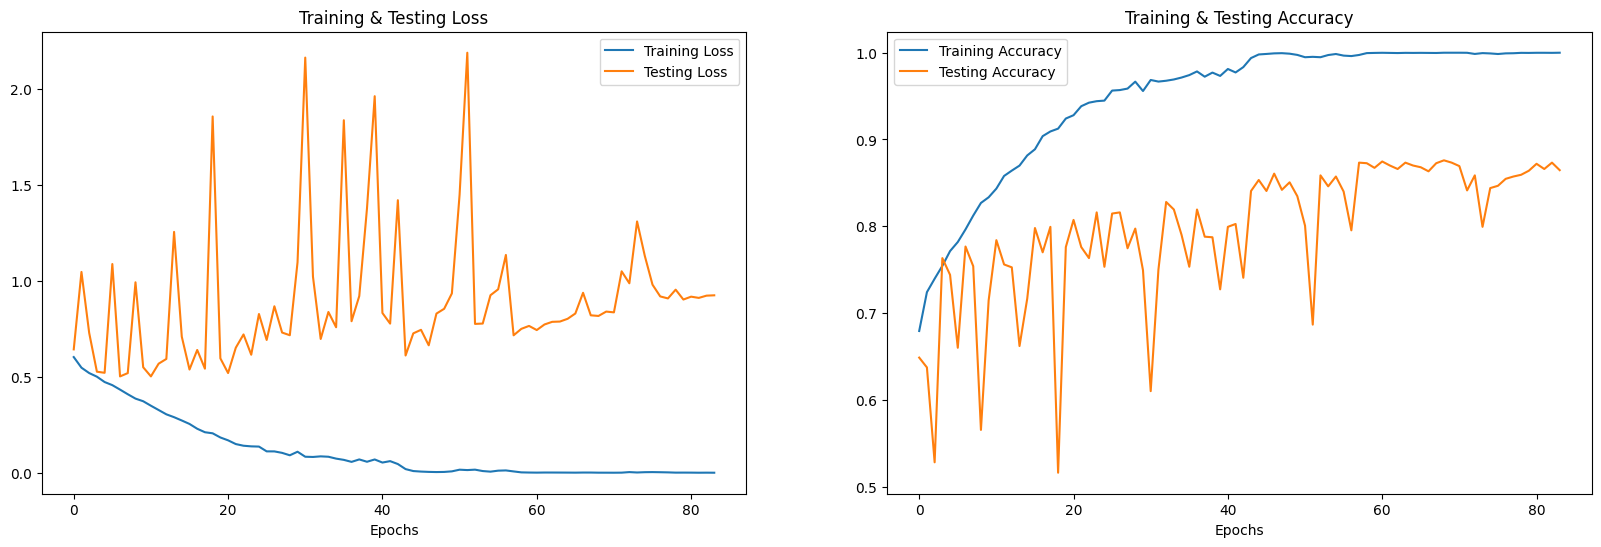

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(x_val,y_val)[1]*100 , "%")

epochs = [i for i in range(84)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['acc']
train_loss = history.history['loss']
test_acc = history.history['val_acc']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
# predicting on val data.
y_pred = model.predict(x_val)
len(y_pred)

1500

In [ ]:
for i in range(len(y_pred)):
    y_pred[i][0] =round(y_pred[i][0])

In [ ]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_val.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,1.0,True
1,0.0,True
2,1.0,True
3,1.0,True
4,1.0,True
5,1.0,True
6,1.0,False
7,1.0,True
8,1.0,True
9,1.0,True


In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

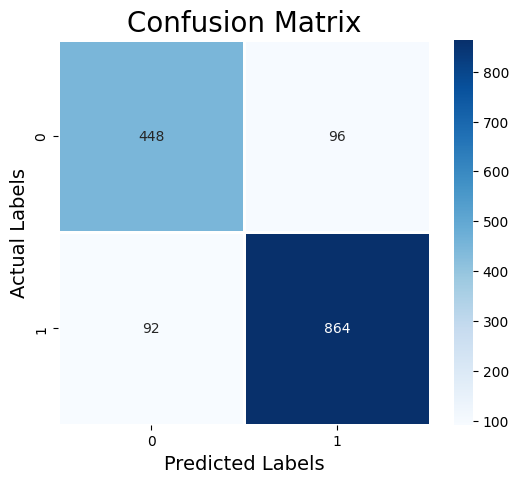

In [ ]:
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize = (6, 5))
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
f1_score(y_val, np.round(model.predict(x_val))),recall_score(y_val, np.round(model.predict(x_val))),accuracy_score(y_val, np.round(model.predict(x_val)))

(0.9018789144050104, 0.9037656903765691, 0.8746666666666667)

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, show_layer_names=True, expand_nested=False)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [ ]:
if CFG.feature_extract_test:
    X, Y = [], []
    for i,file in enumerate(os.listdir(files_dir)[5000:5500]):
        feature = get_features(os.path.join(files_dir,file))
        X.append(feature)
            # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(df["professional-diagnosis"].loc[df["file_name"]==file].values[0])
        if(i%100==0):
            print(i)
    test_features = pd.DataFrame(X)
    test_features['labels'] = Y
    test_features.to_csv('test_features.csv', index=False)
    test_features.head()

In [ ]:
test_features = pd.read_csv("test_features.csv")

In [ ]:
test_features.head(5)

,0,1,2,3,4,5,6,7,8,9,...,865,866,867,868,869,870,871,872,873,labels
0,0.083333,0.196593,0.232184,0.410434,0.959038,0.459528,0.370831,0.447733,0.559178,0.223871,...,1295.430370,1188.427835,1131.367443,1212.189642,1357.534814,1440.050351,1394.131030,1295.153809,1173.510194,True
1,0.099846,0.574448,0.640963,0.567182,0.617855,0.461433,0.420900,0.507860,0.720867,0.768377,...,1008.941380,985.372975,1011.440082,981.509127,989.256712,1014.821007,1048.221391,1075.135023,1020.765866,False
2,0.074958,0.480079,0.331349,0.359254,0.241088,0.491897,0.350522,0.515516,0.456438,0.636179,...,916.940687,899.465795,898.200540,899.802221,910.635415,889.459211,910.151568,924.586913,900.287018,True
3,0.064965,0.999996,0.349046,0.084231,0.108177,0.221526,0.065852,0.160567,0.561014,0.178519,...,787.001283,766.899693,767.517604,742.531608,730.434145,738.419267,734.284443,768.021960,769.633828,True
4,0.048586,0.099845,0.143571,0.472318,0.989016,0.396835,0.114040,0.138395,0.237208,0.092520,...,1017.574598,1044.652662,1023.418930,1028.292075,1154.380415,1162.902760,1190.370686,1212.655064,1097.642249,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.023410,0.175679,0.106942,0.216768,0.339306,0.131207,0.155062,0.238734,0.653328,0.984929,...,738.196756,743.035388,729.355753,688.689778,667.264312,689.079692,677.880440,684.096602,693.030185,False
496,0.080343,0.188157,0.428457,0.172729,0.207122,0.651294,0.354799,0.510452,0.958592,0.450748,...,920.976090,919.010142,896.525123,872.048628,855.686035,857.734066,889.142351,903.750742,942.932000,True
497,0.071925,0.957204,0.415958,0.351987,0.419920,0.460234,0.280257,0.291680,0.578100,0.470296,...,990.656472,978.376985,944.854897,901.369596,836.542232,803.152409,795.049765,783.908644,853.116287,False
498,0.039179,0.610724,0.618714,0.645164,0.660534,0.550436,0.391142,0.315739,0.363418,0.359881,...,1248.364073,1230.654784,1165.145488,1160.283101,1257.273631,1354.025226,1271.910070,1256.470848,1239.635681,True


In [ ]:
x_test = test_features.iloc[: ,:-1].values
y_test = test_features['labels'].values

In [ ]:
x_test = scaler.transform(x_test)
x_test.shape

(500, 874)

In [ ]:
# making our data compatible to model.
x_test = np.expand_dims(x_test, axis=2)
x_test.shape, y_test.shape

((500, 874, 1), (500,))

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

16/16 [==============================] - 0s 13ms/step - loss: 1.8718 - acc: 0.7780
Accuracy of our model on test data :  77.7999997138977 %


In [ ]:
# predicting on test data.
y_pred_test = model.predict(x_test)
len(y_pred_test)

500

In [ ]:
for i in range(len(y_pred_test)):
    y_pred_test[i][0] =round(y_pred_test[i][0])

In [ ]:
df_test = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df_test['Predicted Labels'] = y_pred_test.flatten()
df_test['Actual Labels'] = y_test.flatten()

df_test.head(10)

,Predicted Labels,Actual Labels
0,1.0,True
1,0.0,False
2,0.0,True
3,1.0,True
4,1.0,True
5,0.0,False
6,1.0,True
7,1.0,False
8,0.0,True
9,1.0,True


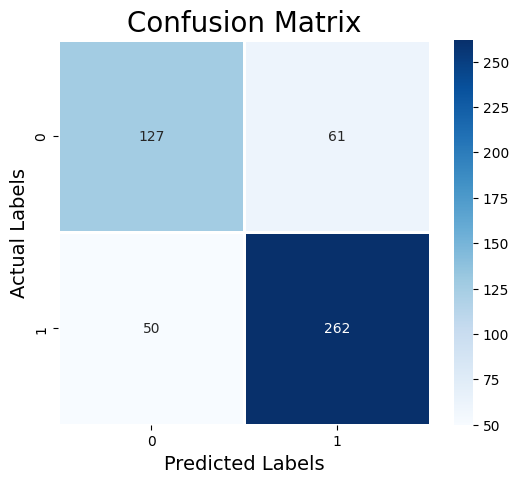

In [ ]:
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize = (6, 5))
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
f1_score(y_test, np.round(model.predict(x_test))),recall_score(y_test, np.round(model.predict(x_test))),accuracy_score(y_test, np.round(model.predict(x_test)))

(0.8251968503937007, 0.8397435897435898, 0.778)